#  OrgNet: A custom YOLO Detector

Greg Lee <br>
03.16.20

**Summary:**

This project represents the implementation of the You Only Look Once (YOLO) algorithm to recognize and quantify intestinal organoids within confocal images. YOLO was implmented by pjreddie as darknet. Herein, I use the pre-trained weights from YOLO on the COCO dataset, altering the last layers of the network for predictions of bounding boxes of class organoid. 

---

**Background** 

Organoids represent an ex-vivo system to grow and study small "mini-organs". When seeded into a gelatinous, three-dimensional extracellular matrix, freshly harvested mammalian intestinal stem cells form organoids. Once plated in gel, these cells self-assemble into a epithelial monolayer surrounded by a central lumen reminiscent of the origin tissue architecture. All cell types of the intestinal niche are present. The robust nature of stem cells allows growth to occur quickly, with mature organoids showing by day seven. Organoid systems enable careful study of the healing response and stem-cell differentiation. Furthermore, they represent a hybrid between traditional animal studies and cell culture studies, enabling high through-put experiments to better study biology.

Organoid assays are often quantified by taking representative images of the gel "domes" which contain between 0-200 growing organoids. Images are taken by a researcher with a 2D confocal micrscope. Following, images are processed with a software such as ImageJ for the number and area of organoids. These data are then used to describe healing, differentiation, etc. 

---
**Architecture**

There are many types of algorithms capable of image detection including YOLO, Region-based Convolutional Neural Networks (R-CNNs), Single Shot Multibox Detectors (SSD) and Histograms of Oriented Gradients (HOGs). Each algorithm excels under certain conditions: 

1. YOLO
    - Fast
    - Works by breaking down the image into smaller segments, analyzing what is within, and drawing bounding boxes, all in one go of the algorithm. [1-3]
2. R-CNNs
    - Accurate
    - Use a pre-trained deep CNN to examine the feature map and produce multiple region proposals and class predictions. Region proposals are based on anchor-boxes. [4]
    - Many flavors: Fast, Faster
3. Single Shot Multibox Detector
    - Alternative Method: Best on Large Objects, worse on small objects
    - Leverages the depth of CNNs to isolate small and large objects with relation to depth in network. [5]
4. Histogram of Oriented Gradients
    - Use combination of HOG and SCale Invariant Feature transformation to identify interest points within images based on normalized local histograms of image gradients. [6]

---
**Goal** 

An implmentation of R-CNNs to quantify organoids was performed by a group at MIT [7]. While this methodology may result in the highest accuracy classification of organoids, it is not fast enough to do real-time detection on a microsope. This project aims to explore if YOLO can achieve roughly equal accuracy on organoid classification, at times fast enough to perform on a microscope. As a researcher, having a tool to quickly quantify organoid images would save many painstaking hours of data collection and processing enabling increased efficiency and assay turn-around. 

---

**Sources:** <br>
[1] https://pjreddie.com/media/files/papers/YOLOv3.pdf <br>
[2] https://martinapugliese.github.io/recognise-objects-yolo/<br>
[3] https://medium.com/@manivannan_data/how-to-train-yolov3-to-detect-custom-objects-ccbcafeb13d2<br>
[4] https://machinelearningmastery.com/object-recognition-with-deep-learning/<br>
[5] https://medium.com/@smallfishbigsea/understand-ssd-and-implement-your-own-caa3232cd6ad<br>
[6] https://mccormickml.com/2013/05/09/hog-person-detector-tutorial/<br>

## Libraries: 

In [2]:
#Basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#Image Libraries: 
import os, sys,glob
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image

#Machine Learning Libraries
#import tensorflow as tf

from sklearn.model_selection import train_test_split

## Getting the Data: 

These images come directly from experiments performed by Greg Lee by Dr. Helong Zhao at the University of Utah. The following protocol was used to grow intestinal organoids from mice: 

C57BL/6J (wildtype) were purchased from Jackson Laboratories. All male and female mice used for intestinal crypt isolation were adults (8–10 weeks old). The isolation procedure was modified from an established protocol [7]. The jejunal sections of the mouse’s small intestine was harvested, opened longitudinally and washed with ice cold 1x phosphate buffer saline (PBS) (Sigma-Aldrich). Mucus and villi were removed using a thin glass coverslip and tissue was cut into 1 cm sections. The tissue pieces were washed in cold PBS and incubated in 30 mM ethylenediaminetetraacetic acid (EDTA) (Sigma-Aldrich), dissolved in PBS, for 8 minutes on ice. Under harsh stripping conditions, dithiothreitol (DTT) (Thermo-Fisher) was added to this solution at a concentration of 1.5 mM. Tissue pieces were transferred to PBS and incubated for 15 minutes on ice. Crypts were liberated by vigorously shaking for 3 minutes and isolated by passage through a 70 mm cell strainer. Purified crypts were pelleted by centrifugation (300 g for 5 minutes at 23 degrees C) and washed twice with PBS to remove any remaining contaminants. All animal studies were approved by University of Utah Institutional Animal Care and Use Committee under protocol number 16-05012 and 18-02010. All animal experiments were conducted in accordance with National Institute of Health Guide for the Care and Use of Laboratory Animals.

Isolated crypts were counted then pelleted by centrifugation (300 g for 5 minutes at 23 degrees C). 1000 crypts were suspended in 80 mL of 50% growth-factor-reduced phenol-red-free Matrigel (Corning) diluted in conditioned LWRN culture medium containing WNT3a, R-spondin, and Noggin. This suspension was pipetted onto the center of a 24 well plate to create a dome. Each gel polymerized at 37°C for 20 minutes. 750 mL of media containing a treatment (singularly including b-estradiol (Sigma-Aldrich), 4-hydroxytamoxifen (Cayman), and G15 (Tocris)) was added to fully submerge the gel. Media was changed every 3 to 4 days, with treatment maintenance throughout. Organoids were counted under 4x magnification with images captured on the EVOSTM Auto Imaging System 4 and 7 days after plating. The number of organoids was normalized per each experiment. 

The images used for this project represent organoids, seven days after seeding. The organoid data is too large to upload to github. This folder represents a small subsample of images. If you have an interest in utilizing this data, please shoot me an email: greglee1905@icloud.com

[7] Hamilton KE, Crissey MA, Lynch JP, et al. (2015, May.). Culturing adult stem cells from mouse small intestinal crypts. Cold Spring Harbor Protocols.1940-3402. <br>

In [2]:
#Grab Data: 
directory = './sample_images'
org_files = []
for file in os.listdir(directory):
    if file.endswith(".jpg"):
        org_files.append(os.path.join(directory, file))
        
#Data Shape: 
print("Sample Dataset: {0} images".format(len(org_files)))

Sample Dataset: 10 images


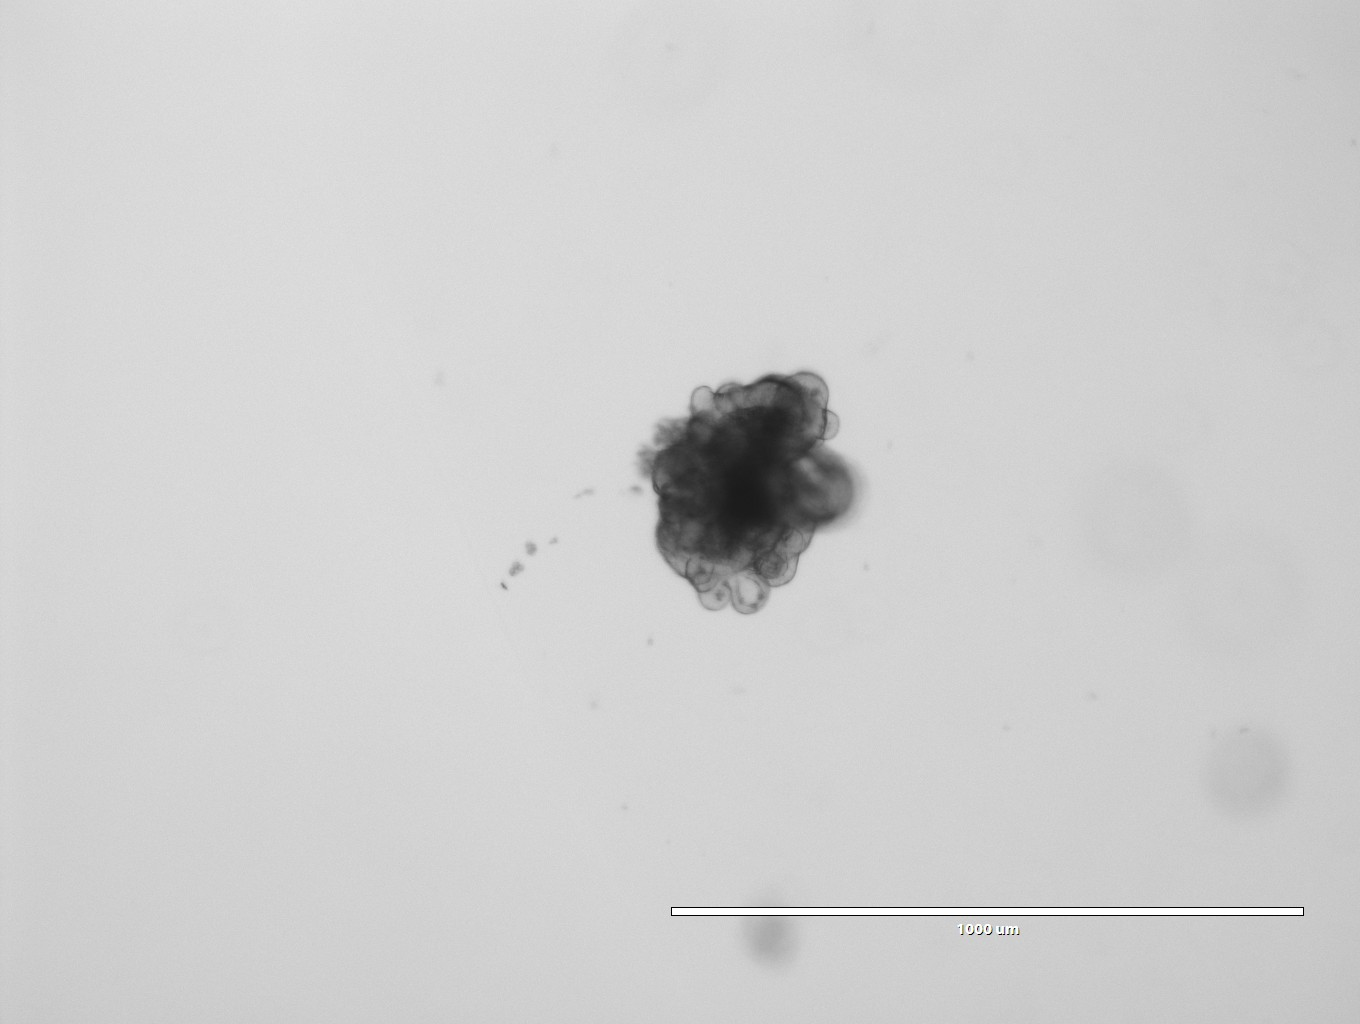

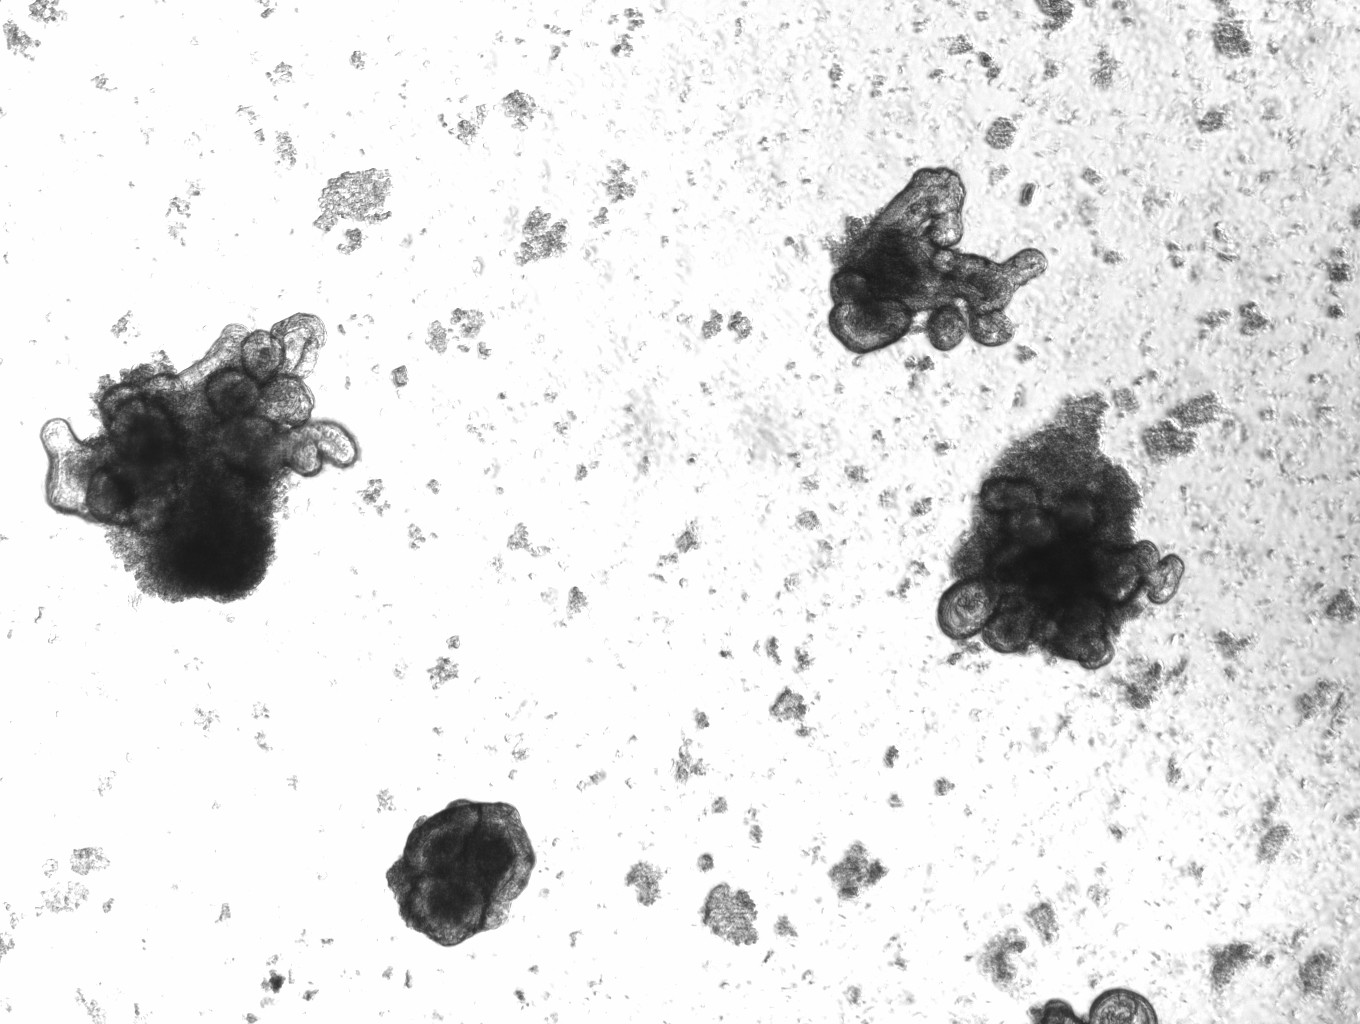

In [3]:
#What do the images look like?
display(_Imgdis(filename=org_files[6], width=400, height=400))
display(_Imgdis(filename=org_files[4], width=400, height=400))

In [4]:
#Image Dimensions
sample_image = Image.open(org_files[0])
print("The shape of the image is: {0} x {1}".format(sample_image.size[0],sample_image.size[1]))

The shape of the image is: 1360 x 1024


## Data Pre-Processing 
YOLO needs the images in a specific format and dimension to work! Let's condense down the images for processing.

In [5]:
#Raw Data Shape: 
org_images = {}

for i,filename in enumerate (org_files):
    try:
        save_name = str(i).zfill(4) + '.jpg'
        sample_image = Image.open(filename)
        sample_image = sample_image.resize((256, 256), Image.ANTIALIAS)
        org_images.update({save_name: sample_image})
    except:
        print("Something went wrong")

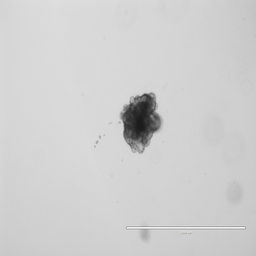

In [6]:
#Compressed images!
org_images['0006.jpg']

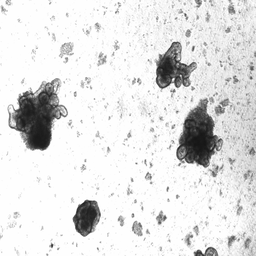

In [7]:
org_images['0004.jpg']

## Data Labeling: 

YOLO follows a very specific labeling method utilizing bounding boxes. In order to create labels for all images, labelImg was utilizd. In order to download and setup the GUI, follow this link (https://github.com/tzutalin/labelImg). If labeling more images, make sure to select 'YOLO' as the label format, not 'PASCAL/VOC'. All images were hand labeled by Ryan Boekholder and Greg Lee.

Note: Some images contained no organoids. These were labeled with empty .txt files. 

In [8]:
#Import Sample Image Labels: 
directory = './sample_labels'
org_labels = {}
for file in os.listdir(directory):
    if file.endswith(".txt"):
        org_labels.update({file:os.path.join(directory, file)})
        
org_labels_dict = {}
tot_org = {}

for key in org_labels:
    try:
        sample_label = pd.read_csv(org_labels[key],header = None, sep = " ")
        org_labels_dict.update({key: sample_label})
        tot_org.update({key: len(sample_label)})
        
    except:
        print("Something went wrong")

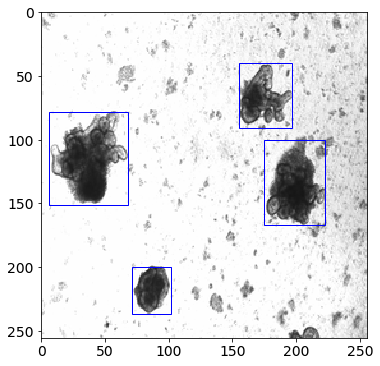

In [46]:
#Visualize bounding boxes on images: 
im = np.array(org_images['0004.jpg'], dtype=np.uint8)
box_labels = pd.DataFrame(org_labels_dict['0004.txt'])
box_labels= box_labels* 256 #Multiply by the shape of the image as YOLO string formats are a ratio of the image size

# Create figure and axes
fig,ax = plt.subplots(1,figsize=(8, 6))
ax.imshow(im)

#Add the bounding boxes to the figures: 
for row in range(box_labels.shape[0]):
    rect = patches.Rectangle((box_labels.iloc[row,1]-box_labels.iloc[row,3]/2,
                          box_labels.iloc[row,2]-box_labels.iloc[row,4]/2),
                         box_labels.iloc[row,3],box_labels.iloc[row,4],linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

plt.show()

## Data Exploration
Let's take a look at the distribution of labels to see if there are any outliers or odd images. Here we load a csv file of all organoid data. 

In [28]:
org_data = pd.read_csv('org_data.csv')
org_data  = org_data.drop(columns = ['Unnamed: 0'])
org_data.head()

,FileNames,Label_FileNames,Label,Total_Organoids,Image
0,0002_resize.jpg,0002_resize.txt,[[0. 0.478516 0.429688 0.136719 0.148438]],1,[[[206 206 206]\n [206 206 206]\n [206 206 2...
1,0003_resize.jpg,0003_resize.txt,[[0. 0.667969 0.410156 0.070312 0.109375...,2,[[[139 139 139]\n [124 124 124]\n [126 126 1...
2,0004_resize.jpg,0004_resize.txt,[[0. 0.357422 0.765625 0.113281 0.140625...,4,[[[133 133 133]\n [131 131 131]\n [135 135 1...
3,0005_resize.jpg,0005_resize.txt,[[0. 0.617188 0.652344 0.109375 0.171875...,5,[[[136 136 136]\n [133 133 133]\n [129 129 1...
4,0006_resize.jpg,0006_resize.txt,[[0. 0.826172 0.462891 0.160156 0.175781...,5,[[[223 223 223]\n [222 222 222]\n [217 217 2...


Text(0.5, 1.0, 'Histogram: Organoids per Image')

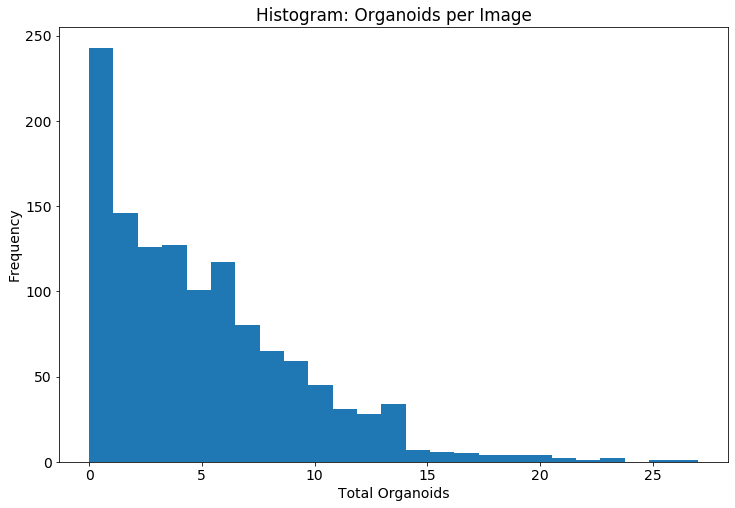

In [32]:
#Visualize histogram of label distribution
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
org_data['Total_Organoids'].plot.hist(bins = 25, ax = ax)
ax.set_xlabel("Total Organoids")
ax.set_title('Histogram: Organoids per Image')

In [35]:
org_data['Total_Organoids'].describe()

count    1239.000000
mean        5.234867
std         4.084394
min         0.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        27.000000
Name: Total_Organoids, dtype: float64

**Conclusion**
1. In total there are 1,239 labeled organoid images. 
2. Overall it appears the distribution of organoids is heavily skewed to the right. Most of the selected images appear to have under 10 total organoids. This detail is important for those considering using this classifier on more densely seeded organoid cultures.
3. On average there are roughly 5 total organoids per image. The media of the data is 4, perhaps a better metric for the middle of the data based on the skew.
4. The minimimum number of organoids is zero and the maximum is 27. 

# Data Augmentation to Expand Data:

This initial grouping of images is relatively small. In order to scale-up the size of the data, we can leverage data augmentation. Employed are the following transformations: 

1. rotations
2. exposure

These changes were selected as they create images which could still pass for organoids. This process was done utilizing a resource described on github (https://github.com/Paperspace/DataAugmentationForObjectDetection). 

Presented below are several images with applied transformations.

In [39]:
from data_aug.data_aug import *
from data_aug.bbox_util import *

In [92]:
im = np.array(org_images['0004.jpg'], dtype=np.uint8)
box_labels = pd.DataFrame(org_labels_dict['0004.txt'])
box_labels= box_labels* 256

cols = box_labels.columns.tolist()
cols =  cols[1:] + cols[:1]
test = box_labels[cols]
bboxes = test.to_numpy()

bboxes_form = []
for row in range(bboxes.shape[0]):
    x1 = box_labels.iloc[row,1]-box_labels.iloc[row,3]/2
    y1 = box_labels.iloc[row,2]-box_labels.iloc[row,4]/2
    x2 =  box_labels.iloc[row,1]+box_labels.iloc[row,3]/2
    y2 = box_labels.iloc[row,2]+box_labels.iloc[row,4]/2
    temp = [x1,y1,x2,y2,0]
    bboxes_form.append(temp)

<Figure size 432x288 with 0 Axes>

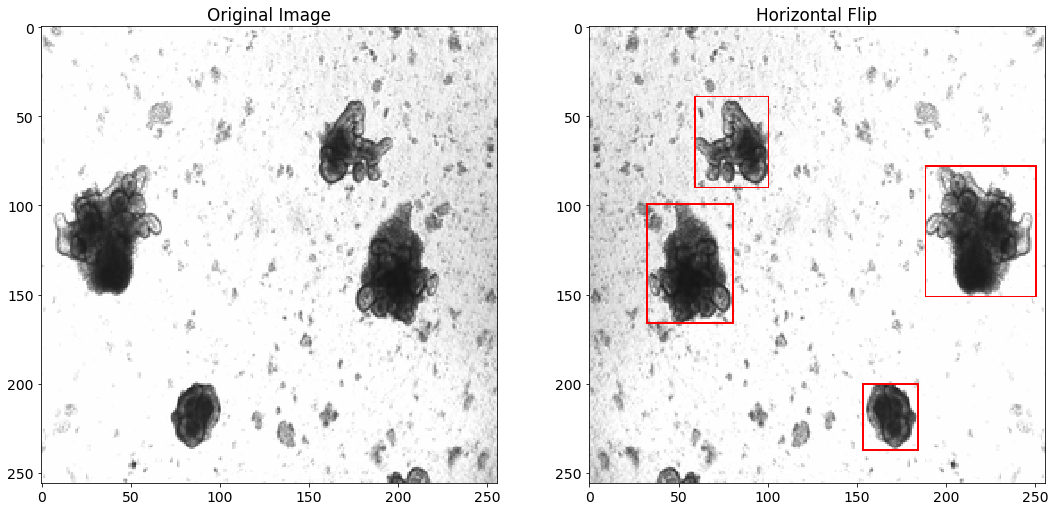

In [111]:
#Rotational_flip
img_, bboxes_ = RandomHorizontalFlip(1)(im.copy(), np.array(bboxes_form).copy())
plt.figure()
fig,ax = plt.subplots(1,2,figsize=(18, 9))
plotted_img = draw_rect(img_, bboxes_, color = [255,0,0])
ax[1].imshow(plotted_img)
ax[1].set_title('Horizontal Flip')
ax[0].imshow(im)
ax[0].set_title('Original Image')
plt.show()

<Figure size 432x288 with 0 Axes>

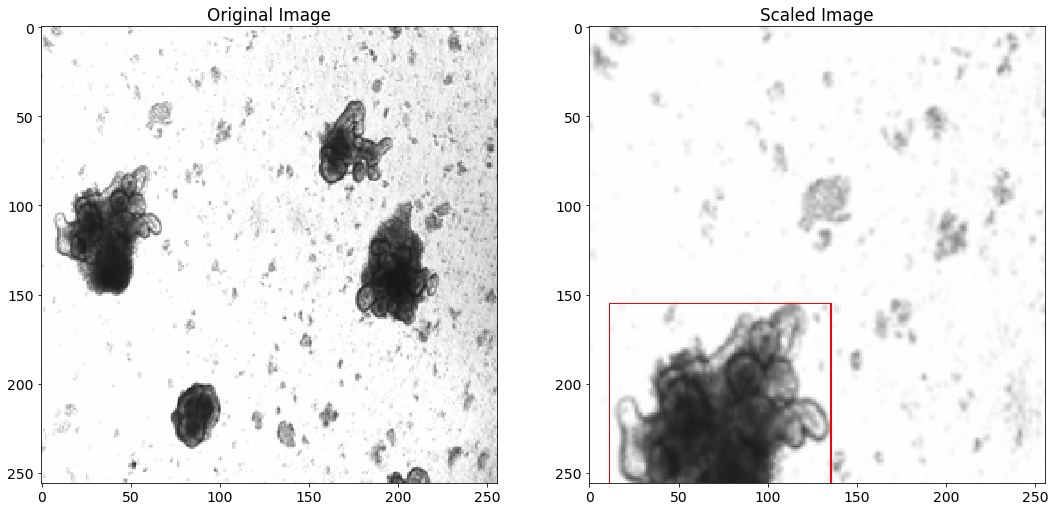

In [113]:
#Scaling:
img_, bboxes_ = RandomScale(1)(im.copy(), np.array(bboxes_form).copy())
plt.figure()
fig,ax = plt.subplots(1,2,figsize=(18, 9))
plotted_img = draw_rect(img_, bboxes_, color = [255,0,0])
ax[1].imshow(plotted_img)
ax[1].set_title('Scaled Image')
ax[0].imshow(im)
ax[0].set_title('Original Image')
plt.show()

<Figure size 432x288 with 0 Axes>

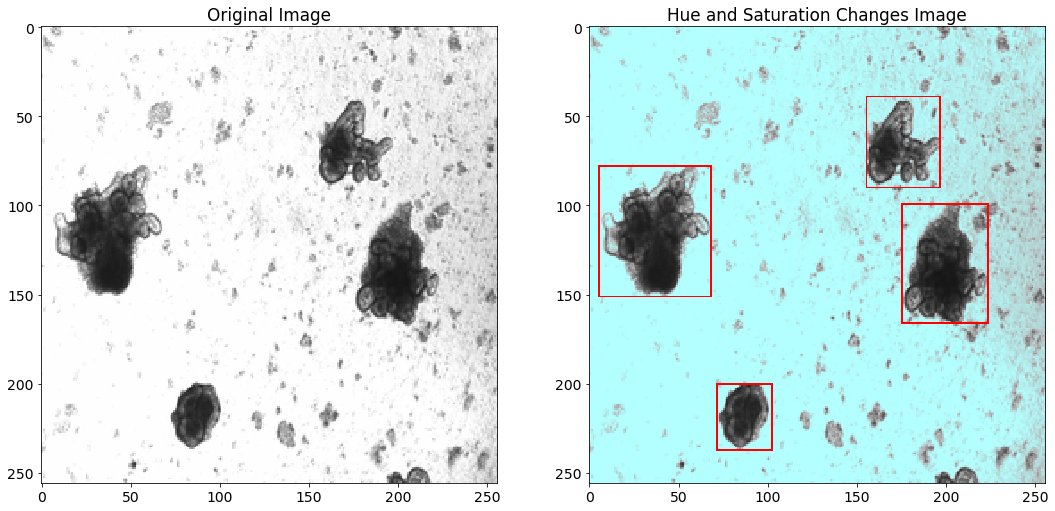

In [119]:
#Scaling:
img_, bboxes_ = RandomHSV()(im.copy(), np.array(bboxes_form).copy())
plt.figure()
fig,ax = plt.subplots(1,2,figsize=(18, 9))
plotted_img = draw_rect(img_, bboxes_, color = [255,0,0])
ax[1].imshow(plotted_img)
ax[1].set_title('Hue and Saturation Changes Image')
ax[0].imshow(im)
ax[0].set_title('Original Image')
plt.show()

These operations were performed on all data to triple the size of the training data.

# Implementing YOLO: Darknet

In order to run YOLO, the darknet framework was selected for training. To view the documentation on this resource please visit: https://pjreddie.com/darknet/. In order to clone the Darknet repository, simply toggle to your desired directory. Then uncomment and run the following code

In [ ]:
#Get Darknet!
#!git clone https://github.com/pjreddie/darknet
#!cd darknet
#!make

### Preparing the Data: 
In order to run YOLO, the data must be in a select location within the darknet . All proccessed pairs of images (.jpg) and labels (.txt) files should be in a desired location. **All** images and labels should be located within this folder. 

In [145]:
#Within the darknet directory:
!mkdir ./darknet/org_images
!mkdir ./darknet/org_images/JPEGImage

Move all images and labels into this directory.

In [ ]:
#MAYBE ADD SOMEHTING MORE ABOUT HOW TO DO THIS? 

### Split the data into a test and train set
When fitting the data to the darknet workflow, a test and train file need to be created which are path directories to each file allocated to be a testing or training example. This may done with the following code: 

In [153]:
#Splitting the data into a test and train set (ONLY LABELS)
#Darknet only needs the label files, as long as the labels and files are identical (aside from .txt vs .jpg)
from sklearn.model_selection import train_test_split
train_set_x, test_set_x, train_set_y, test_set_y = train_test_split(org_data, org_data, test_size=0.20, random_state=2)

#What are the sizes?
print("Using a total split of 80% training and 20% testing")
print("The size of the training set is : %d" % train_set_x.shape[0])
print("The size of the validation set is : %d" % test_set_x.shape[0])

Using a total split of 80% training and 20% testing
The size of the training set is : 991
The size of the validation set is : 248


In [154]:
#Saving the Test and Train Sets

#Directory should be fully written out to avoid errors
directory = '/Users/greglee/Data_Science/Organoid_Recognition/darknet' 

#TRAINING SPLIT
train_labels_with_path = pd.DataFrame(columns =["FileNames"])
train_labels_with_path['FileNames'] = directory + '/org_images/JPEGImage/' + train_set_x['FileNames'].astype(str)
train_labels_with_path.to_csv('train.txt',sep='\n',index = False,header = False)

#TEST SPLIT
test_labels_with_path = pd.DataFrame(columns =["FileNames"])
test_labels_with_path['FileNames'] =  directory + '/org_images/JPEGImage/' + test_set_x['FileNames'].astype(str)
test_labels_with_path.to_csv('test.txt',sep='\n',index = False,header = False) 

### Creating .cfg , .data, and .names Files

**organoid_tiny.cfg** <br> 
The organoid_tiny.cfg represents the configurations for the network setup. This file lies in the darknet/cfg directory.

These changes have been made from the original darknet:

1. line 2: batch = 24
2. line 6: batch = 24
3. line 8: width=256
4. line 9: height=256
5. line 127: filters = 18
6. line 135: classes = 1
7. line 171: filters = 18
8. line 177: classes = 1

This file is saved in the darknet folder as organoid_tiny.cfg

**organoid_classes.names**<br>
This file represents a simple list, by line of labels within the images. Since we are only attempting to classify organoids, we will have only one file. This file should lie within the darknet directory. 

Example Code:

Organoids

**organoid_tiny.data** <br>
Next the organoid_tiny.data was created which contains the directory information concerning test, train, labels and the backup folder. To minimize bugs, use the full directory name. This file lies in the darknet/cfg directory.

Example Code: 

classes = 1
train = /Users/greglee/Data_Science/Organoid_Recognition/darknet/train.txt<br>
valid = /Users/greglee/Data_Science/Organoid_Recognition/darknet/test.txt<br>
names = /Users/greglee/Data_Science/Organoid_Recognition/darknet/org_classes.names<br>
backup = /Users/greglee/Data_Science/Organoid_Recognition/darknet/backup<br>

**To take a look or use these files, see the darknet_configs file.**

## Training

Once everything is set-up, training may be ran by a simple terminal command within the darknet directory!

./darknet detector train cfg/organoid_tiny.data cfg/organoid_tiny.cfg darknet53.conv.74

Training on a CPU takes forever. If you have a GPU, definetely use it! Weights are saved in the backup folder for the network. Different specifications can be used to alter how the batch size, how often weights are saved, etc. Choose parameters which best fit your technology setup. I have saved the weights of training the algorithm within the main directory as org_gpu.weights.

## Testing
Use the command below to test detector on new, never-before seen data!

In [ ]:
!./darknet detector test cfg/obj.data cfg/yolov3-tiny.cfg backup/yolov3-tiny_900.weights data/test.jpg

# Using OrgNet to Make Predictions: 

Training was performed on a NVIDIA 2070 SUPER GPU for five days in total. Transfer learning was utilized in order to decrease the total amount of training time for the algorithm. Thus, the weights were intialized on Redmon's original darknet.53.conv.74, trained on the COCO dataset. Thereafter, the last two layers of the network were adapted to detect only one class of object. This tatic is used to so the COCO-trained shape detectors of the original darknet layers are utilized. Thus, the network can "focus" on recognition of the desired new class, ie Organoids!

The algorithm was tested on a hold-out set of 20 organoid images. On this set, the classifier achieved an accuracy of ~77%. Overall, not too bad for a first go! Interestingly, the overall mean average precision appeared to increase between a training of tiny-yolo on a CPU and yolo on a gpu! Below are some representative images to showcase where the classifier excelled and struggled! 

<Figure size 432x288 with 0 Axes>

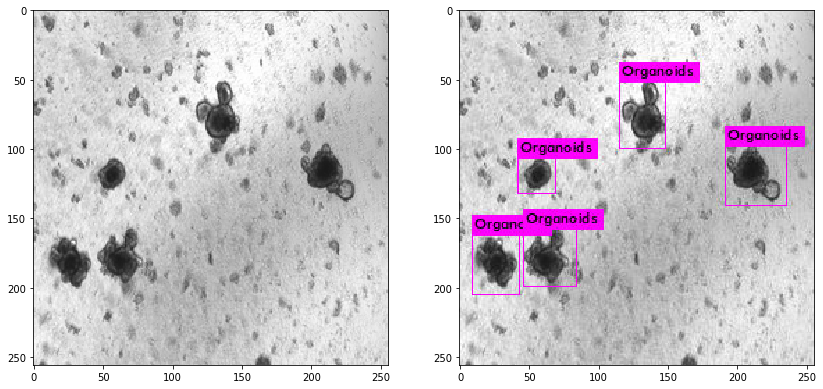

In [14]:
#Import Images
im_pred = np.array(Image.open("./results/test_1_preds.jpg"), dtype=np.uint8)
im = np.array(Image.open("./results/test_1.jpg"), dtype=np.uint8)

plt.figure()
fig,ax = plt.subplots(1,2,figsize=(14, 7))
ax[0].imshow(im)
ax[1].imshow(im_pred)

<Figure size 432x288 with 0 Axes>

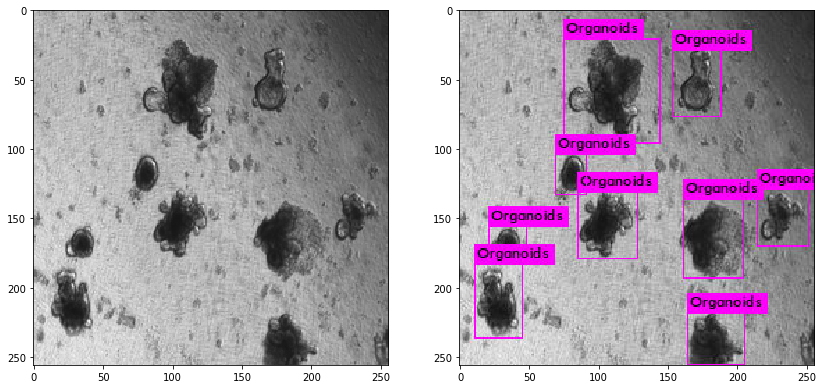

In [16]:
#Import Images
im_pred = np.array(Image.open("./results/test_6_preds.jpg"), dtype=np.uint8)
im = np.array(Image.open("./results/test_6.jpg"), dtype=np.uint8)

plt.figure()
fig,ax = plt.subplots(1,2,figsize=(14, 7))
ax[0].imshow(im)
ax[1].imshow(im_pred)

<Figure size 432x288 with 0 Axes>

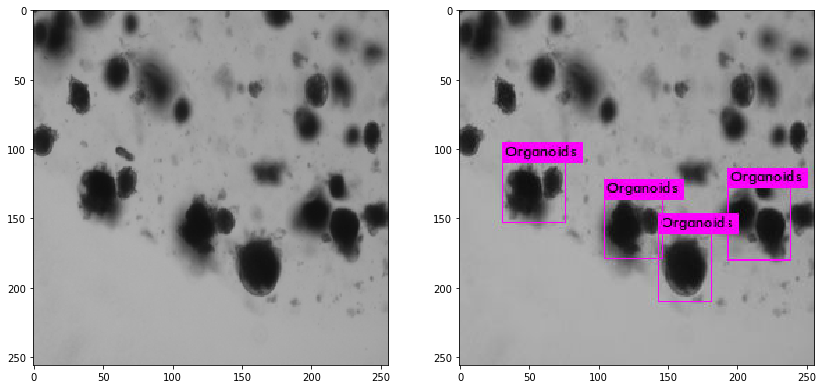

In [19]:
#Import Images
im_pred = np.array(Image.open("./results/test_4_preds.jpg"), dtype=np.uint8)
im = np.array(Image.open("./results/test_4.jpg"), dtype=np.uint8)

plt.figure()
fig,ax = plt.subplots(1,2,figsize=(14, 7))
ax[0].imshow(im)
ax[1].imshow(im_pred)

# Conclusion and Looking Forward: 

Errors: 
    blurry
    lots of organoids (not as many training examples)
    Use dataset from orgaquant

Excels: 
    minimal noise
    high focus
    Ideal settings

Forward:
    video processing
    accessible GUI

# Extra Functions 

In [3]:
#Function to standardize numerical names seperated by  "_"
def name_num_standardize(directory, placeholders, follow_name):
    
    """
    Standardizes files with lists of numbered data. Fills with zeros to a desired length.
    
    Arguments:
    directory -- Computer path to file
    placeholders -- The desired number of placeholder values
    follow_name -- File type and rest of name. All files should maintain this as identical.
        
    Returns:
    No returns. Should edit the files directly!
    """
    for file in os.listdir(directory):
        new_name = file.split("_",1)[0].zfill(placeholders) + follow_name
        os.rename(directory + file, directory + new_name)  
    